In [1]:
import numpy as np
import pandas as pd
#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV

# Model Selection and Metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, reset_parameter
from sklearn.metrics import f1_score, recall_score, accuracy_score, roc_auc_score, precision_score, auc, roc_curve

# Hyperparamter Tuning
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform



In [2]:
train =pd.read_csv('train.csv')

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


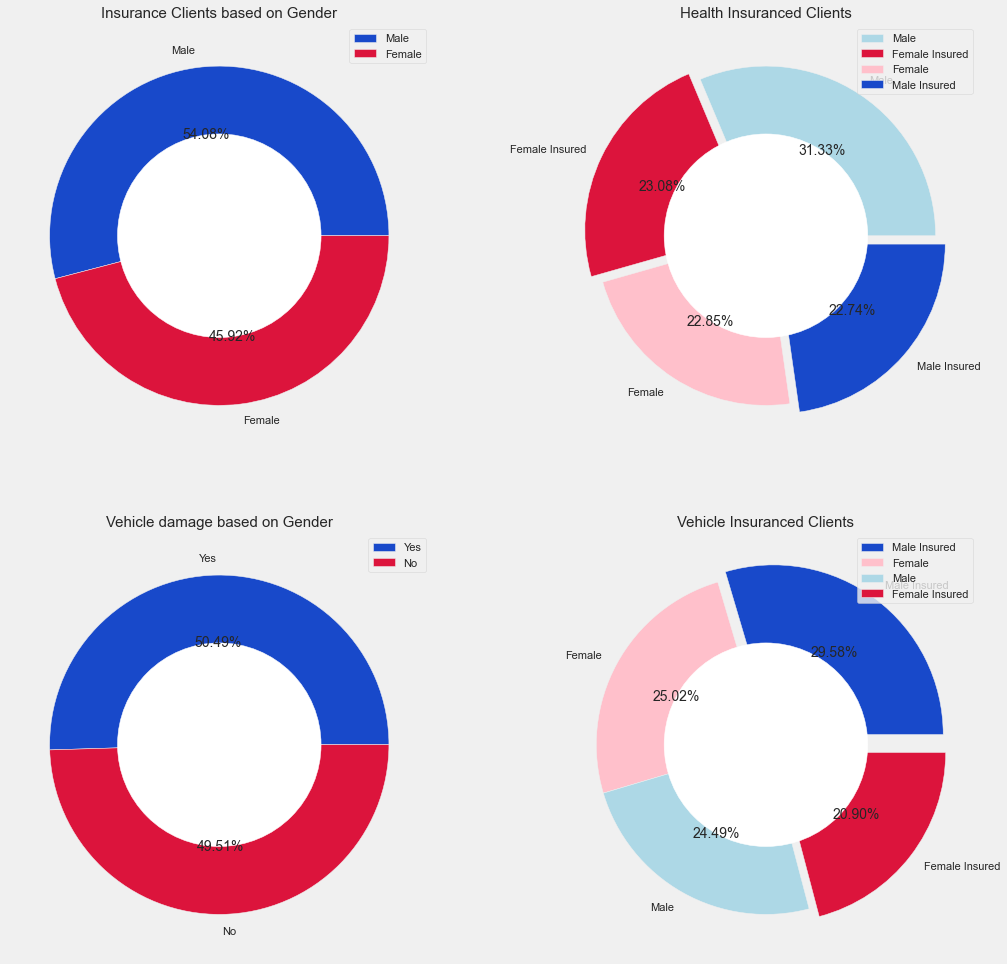

In [4]:
sns.set(style="darkgrid")
plt.style.use('fivethirtyeight')

plt.subplot(221)
colors = ['#1849CA', 'crimson']
plt.title('Insurance Clients based on Gender',fontsize=15)
circle = plt.Circle((0, 0), 0.6, color = 'white')
train['Gender'].value_counts().plot(kind='pie', figsize=(8, 8), rot=1, colors=colors, autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()

plt.subplot(222)
colors = ['lightblue', 'crimson', 'pink', '#1849CA']
explode = [0, 0.075, 0, 0.075]
plt.title('Health Insuranced Clients',fontsize=15)
circle = plt.Circle((0, 0), 0.6, color = 'white')
health = train[['Gender','Previously_Insured']].values.tolist()
health = pd.DataFrame([h[0] + ' Insured' if h[1] == 1 else h[0] for h in health ],columns=['Gen_Ins'])
health['Gen_Ins'].value_counts().plot(kind='pie', explode=explode, figsize=(16, 16), rot=1, colors=colors, autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()

plt.subplot(223)
colors = ['#1849CA', 'crimson']
plt.title('Vehicle damage based on Gender',fontsize=15)
circle = plt.Circle((0, 0), 0.6, color = 'white')
train['Vehicle_Damage'].value_counts().plot(kind='pie',figsize=(16, 16), rot=1, colors=colors, autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()

plt.subplot(224)
colors = ['#1849CA', 'pink', 'lightblue', 'crimson']
explode = [0.075, 0, 0, 0.075]
plt.title('Vehicle Insuranced Clients',fontsize=15)
circle = plt.Circle((0, 0), 0.6, color = 'white')
health = train[['Gender','Vehicle_Damage']].values.tolist()
health = pd.DataFrame([h[0] + ' Insured' if h[1] == 'Yes' else h[0] for h in health ],columns=['Veh_Ins'])
health['Veh_Ins'].value_counts().plot(kind='pie', explode=explode, figsize=(16, 16), rot=1, colors=colors, autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()


plt.show()

### Age is definitely affecting the Response as we can observe in below plots

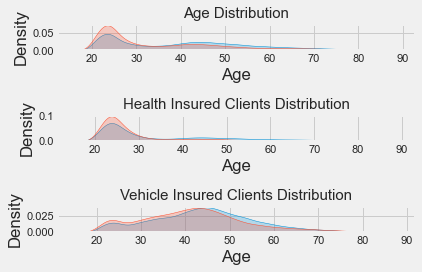

In [5]:
plt.subplot(311)
plt.title('Age Distribution',fontsize=15)
men = train[train['Gender']=='Male']
women = train[train['Gender']=='Female']
a = sns.kdeplot(men['Age'], shade='True', legend='True', label='Male')
b = sns.kdeplot(women['Age'], shade='True', legend='True', label='Female')

plt.subplot(312)
plt.title('Health Insured Clients Distribution',fontsize=15)
health = train[['Gender','Previously_Insured','Age']]
health = health[health['Previously_Insured'] == 1]
men = health[health['Gender']=='Male']
women = health[health['Gender']=='Female']
a = sns.kdeplot(men['Age'], shade='True', legend='True', label='Male')
b = sns.kdeplot(women['Age'], shade='True', legend='True', label='Female')

plt.subplot(313)
plt.title('Vehicle Insured Clients Distribution',fontsize=15)
health = train[['Gender','Response','Age']]
health = health[health['Response'] == 1]
men = health[health['Gender']=='Male']
women = health[health['Gender']=='Female']
a = sns.kdeplot(men['Age'], shade='True', legend='True', label='Male')
b = sns.kdeplot(women['Age'], shade='True', legend='True', label='Female')

plt.tight_layout()
plt.show()

### Vehicle Damage is clearly related to Response, clients whose vehicle never damaged didn't opt for Vehicle Insurance

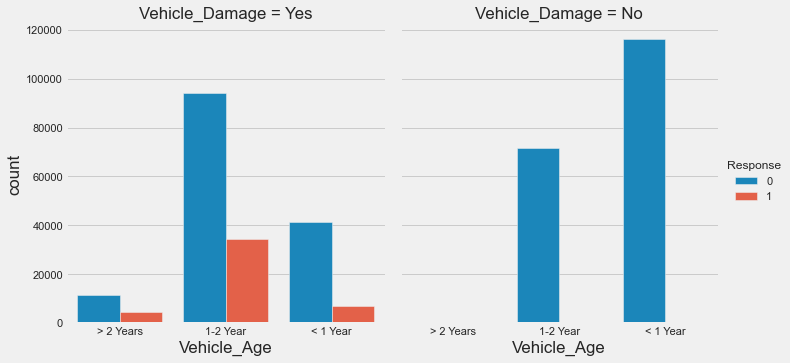

In [6]:
ax = sns.catplot(data=train, x='Vehicle_Age', hue='Response', col='Vehicle_Damage', kind='count')

<a id="section-two"></a>
# Feature Engineering

* Need to encode categorical data to integers
* We will Drop of Vintage and Annual Premium as we observe their impact on Response is not encouraging
* Need to scale all parameters which makes easy for algorith to reach minima

In [8]:
train['Gender_Code'] = pd.CategoricalIndex(train['Gender']).codes
train['Vehicle_Age_code'] = pd.CategoricalIndex(train['Vehicle_Age']).codes
train['Vehicle_Damage_code'] = pd.CategoricalIndex(train['Vehicle_Damage']).codes 

In [9]:
model_train = train[['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
                   'Policy_Sales_Channel', 'Gender_Code',
                   'Vehicle_Age_code', 'Vehicle_Damage_code']]

scaler = StandardScaler()

for param in ['Age',
              'Driving_License',
              'Region_Code',
              'Previously_Insured',
              'Policy_Sales_Channel',
              'Gender_Code',
              'Vehicle_Age_code',
              'Vehicle_Damage_code']:
    model_train[param] = scaler.fit_transform(model_train[param].values.reshape(-1, 1))
    
X_train, X_test, y_train, y_test = train_test_split(model_train, train['Response'], test_size = 0.2, shuffle = True)

<ipython-input-9-429c8b73219d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train[param] = scaler.fit_transform(model_train[param].values.reshape(-1, 1))
<ipython-input-9-429c8b73219d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train[param] = scaler.fit_transform(model_train[param].values.reshape(-1, 1))
<ipython-input-9-429c8b73219d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

<a id="section-three"></a>
# Model Selection 


    
* Problem can be identified as Binary Classification (wheather customer opts for vehicle insurance or not)
* Dataset has more than 300k records
* cannot go with SVM Classifier as it takes more time to train as dataset increase
* Idea is to start selection of models as:

    1. Decision Tree
    2. Random Forest
    3. SGD
    4. Gradient Boost
    5. XG Boost
    6. Cat Boost
    7. LGBM
    

    
    
    
## Boosting Models

### Boosting is one of the techniques that uses the concept of ensemble learning. A boosting algorithm combines multiple simple models

In [10]:
model = {
    "Decision Tree": DecisionTreeClassifier(), 
    "SGD" : SGDClassifier(), 
    "Random Forest" : RandomForestClassifier(), 
    "Gradient Boosting" : GradientBoostingClassifier(),
    "XGBoost" : XGBClassifier(),
    "CatBoost" : CatBoostClassifier(),
    "LGBM" : LGBMClassifier()
        }


In [11]:
scores = []
prob_score = {}
for mod in model:
    classifier = model[mod]
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    try:
        score = classifier.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y_test, score, average='weighted')
        prob_score[mod] = score
    except:
        roc = 0
    scores.append([
        mod,
        accuracy_score(y_test, pred),
        f1_score(y_test, pred, average='weighted'),
        precision_score(y_test, pred, average='weighted'),
        recall_score(y_test, pred, average='weighted'),
        roc
    ])

C:\Users\New folder\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\New folder\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.118484
0:	learn: 0.5037702	total: 218ms	remaining: 3m 37s
1:	learn: 0.4046298	total: 325ms	remaining: 2m 42s
2:	learn: 0.3531443	total: 432ms	remaining: 2m 23s
3:	learn: 0.3246898	total: 549ms	remaining: 2m 16s
4:	learn: 0.3078718	total: 631ms	remaining: 2m 5s
5:	learn: 0.2966530	total: 703ms	remaining: 1m 56s
6:	learn: 0.2894254	total: 771ms	remaining: 1m 49s
7:	learn: 0.2847017	total: 840ms	remaining: 1m 44s
8:	learn: 0.2812492	total: 946ms	remaining: 1m 44s
9:	learn: 0.2785901	total: 1.04s	remaining: 1m 42s
10:	learn: 0.2765354	total: 1.13s	remaining: 1m 41s
11:	learn: 0.2748282	total: 1.2s	remaining: 1m 38s
12:	learn: 0.2736142	total: 1.27s	remaining: 1m 

151:	learn: 0.2632914	total: 13.2s	remaining: 1m 13s
152:	learn: 0.2632764	total: 13.3s	remaining: 1m 13s
153:	learn: 0.2632596	total: 13.4s	remaining: 1m 13s
154:	learn: 0.2632339	total: 13.5s	remaining: 1m 13s
155:	learn: 0.2632199	total: 13.6s	remaining: 1m 13s
156:	learn: 0.2632078	total: 13.7s	remaining: 1m 13s
157:	learn: 0.2631904	total: 13.8s	remaining: 1m 13s
158:	learn: 0.2631726	total: 13.9s	remaining: 1m 13s
159:	learn: 0.2631639	total: 13.9s	remaining: 1m 13s
160:	learn: 0.2631502	total: 14s	remaining: 1m 13s
161:	learn: 0.2631364	total: 14.1s	remaining: 1m 13s
162:	learn: 0.2631204	total: 14.2s	remaining: 1m 12s
163:	learn: 0.2631094	total: 14.3s	remaining: 1m 12s
164:	learn: 0.2630960	total: 14.3s	remaining: 1m 12s
165:	learn: 0.2630848	total: 14.4s	remaining: 1m 12s
166:	learn: 0.2630773	total: 14.5s	remaining: 1m 12s
167:	learn: 0.2630627	total: 14.6s	remaining: 1m 12s
168:	learn: 0.2630492	total: 14.7s	remaining: 1m 12s
169:	learn: 0.2630216	total: 14.7s	remaining: 1m

311:	learn: 0.2613121	total: 26.4s	remaining: 58.3s
312:	learn: 0.2613043	total: 26.5s	remaining: 58.2s
313:	learn: 0.2612938	total: 26.6s	remaining: 58.1s
314:	learn: 0.2612881	total: 26.7s	remaining: 58s
315:	learn: 0.2612761	total: 26.7s	remaining: 57.9s
316:	learn: 0.2612641	total: 26.8s	remaining: 57.8s
317:	learn: 0.2612543	total: 26.9s	remaining: 57.7s
318:	learn: 0.2612471	total: 27s	remaining: 57.6s
319:	learn: 0.2612440	total: 27s	remaining: 57.4s
320:	learn: 0.2612361	total: 27.1s	remaining: 57.3s
321:	learn: 0.2612261	total: 27.2s	remaining: 57.2s
322:	learn: 0.2612156	total: 27.3s	remaining: 57.1s
323:	learn: 0.2612099	total: 27.3s	remaining: 57s
324:	learn: 0.2611982	total: 27.4s	remaining: 57s
325:	learn: 0.2611867	total: 27.5s	remaining: 56.9s
326:	learn: 0.2611759	total: 27.6s	remaining: 56.8s
327:	learn: 0.2611686	total: 27.7s	remaining: 56.8s
328:	learn: 0.2611632	total: 27.8s	remaining: 56.7s
329:	learn: 0.2611563	total: 27.9s	remaining: 56.6s
330:	learn: 0.2611479	

470:	learn: 0.2599668	total: 38.7s	remaining: 43.4s
471:	learn: 0.2599613	total: 38.7s	remaining: 43.3s
472:	learn: 0.2599551	total: 38.8s	remaining: 43.3s
473:	learn: 0.2599470	total: 38.9s	remaining: 43.2s
474:	learn: 0.2599412	total: 39s	remaining: 43.1s
475:	learn: 0.2599314	total: 39.1s	remaining: 43s
476:	learn: 0.2599228	total: 39.1s	remaining: 42.9s
477:	learn: 0.2599161	total: 39.2s	remaining: 42.8s
478:	learn: 0.2599090	total: 39.3s	remaining: 42.7s
479:	learn: 0.2599023	total: 39.4s	remaining: 42.6s
480:	learn: 0.2598935	total: 39.4s	remaining: 42.5s
481:	learn: 0.2598830	total: 39.5s	remaining: 42.5s
482:	learn: 0.2598793	total: 39.6s	remaining: 42.4s
483:	learn: 0.2598714	total: 39.7s	remaining: 42.3s
484:	learn: 0.2598604	total: 39.7s	remaining: 42.2s
485:	learn: 0.2598503	total: 39.8s	remaining: 42.1s
486:	learn: 0.2598440	total: 39.9s	remaining: 42s
487:	learn: 0.2598356	total: 40s	remaining: 41.9s
488:	learn: 0.2598288	total: 40s	remaining: 41.8s
489:	learn: 0.2598263	

630:	learn: 0.2588589	total: 50.6s	remaining: 29.6s
631:	learn: 0.2588548	total: 50.7s	remaining: 29.5s
632:	learn: 0.2588480	total: 50.8s	remaining: 29.4s
633:	learn: 0.2588412	total: 50.8s	remaining: 29.3s
634:	learn: 0.2588350	total: 50.9s	remaining: 29.3s
635:	learn: 0.2588244	total: 51s	remaining: 29.2s
636:	learn: 0.2588173	total: 51s	remaining: 29.1s
637:	learn: 0.2588040	total: 51.1s	remaining: 29s
638:	learn: 0.2587985	total: 51.2s	remaining: 28.9s
639:	learn: 0.2587912	total: 51.3s	remaining: 28.8s
640:	learn: 0.2587856	total: 51.4s	remaining: 28.8s
641:	learn: 0.2587832	total: 51.4s	remaining: 28.7s
642:	learn: 0.2587759	total: 51.5s	remaining: 28.6s
643:	learn: 0.2587706	total: 51.6s	remaining: 28.5s
644:	learn: 0.2587657	total: 51.7s	remaining: 28.4s
645:	learn: 0.2587611	total: 51.7s	remaining: 28.3s
646:	learn: 0.2587543	total: 51.8s	remaining: 28.3s
647:	learn: 0.2587502	total: 51.9s	remaining: 28.2s
648:	learn: 0.2587418	total: 51.9s	remaining: 28.1s
649:	learn: 0.2587

791:	learn: 0.2578768	total: 1m 2s	remaining: 16.5s
792:	learn: 0.2578700	total: 1m 2s	remaining: 16.4s
793:	learn: 0.2578648	total: 1m 2s	remaining: 16.3s
794:	learn: 0.2578615	total: 1m 3s	remaining: 16.3s
795:	learn: 0.2578560	total: 1m 3s	remaining: 16.2s
796:	learn: 0.2578493	total: 1m 3s	remaining: 16.1s
797:	learn: 0.2578459	total: 1m 3s	remaining: 16s
798:	learn: 0.2578423	total: 1m 3s	remaining: 15.9s
799:	learn: 0.2578369	total: 1m 3s	remaining: 15.9s
800:	learn: 0.2578318	total: 1m 3s	remaining: 15.8s
801:	learn: 0.2578269	total: 1m 3s	remaining: 15.7s
802:	learn: 0.2578198	total: 1m 3s	remaining: 15.6s
803:	learn: 0.2578178	total: 1m 3s	remaining: 15.5s
804:	learn: 0.2578103	total: 1m 3s	remaining: 15.4s
805:	learn: 0.2578035	total: 1m 3s	remaining: 15.4s
806:	learn: 0.2577985	total: 1m 3s	remaining: 15.3s
807:	learn: 0.2577950	total: 1m 3s	remaining: 15.2s
808:	learn: 0.2577903	total: 1m 4s	remaining: 15.1s
809:	learn: 0.2577826	total: 1m 4s	remaining: 15s
810:	learn: 0.25

949:	learn: 0.2570024	total: 1m 14s	remaining: 3.94s
950:	learn: 0.2569958	total: 1m 14s	remaining: 3.86s
951:	learn: 0.2569914	total: 1m 15s	remaining: 3.79s
952:	learn: 0.2569835	total: 1m 15s	remaining: 3.71s
953:	learn: 0.2569767	total: 1m 15s	remaining: 3.63s
954:	learn: 0.2569715	total: 1m 15s	remaining: 3.55s
955:	learn: 0.2569674	total: 1m 15s	remaining: 3.47s
956:	learn: 0.2569617	total: 1m 15s	remaining: 3.39s
957:	learn: 0.2569523	total: 1m 15s	remaining: 3.31s
958:	learn: 0.2569494	total: 1m 15s	remaining: 3.23s
959:	learn: 0.2569444	total: 1m 15s	remaining: 3.15s
960:	learn: 0.2569383	total: 1m 15s	remaining: 3.07s
961:	learn: 0.2569369	total: 1m 15s	remaining: 2.99s
962:	learn: 0.2569285	total: 1m 15s	remaining: 2.92s
963:	learn: 0.2569260	total: 1m 15s	remaining: 2.84s
964:	learn: 0.2569211	total: 1m 16s	remaining: 2.76s
965:	learn: 0.2569187	total: 1m 16s	remaining: 2.68s
966:	learn: 0.2569109	total: 1m 16s	remaining: 2.6s
967:	learn: 0.2569028	total: 1m 16s	remaining: 

In [12]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

scores_df  = pd.DataFrame(scores)
index_model = {count: s for count, s in enumerate(scores_df[0])}
col = {count+1: s for count, s in enumerate(['Accuracy','F1 Score','Precision','Recall','ROC AUC'])}
scores_df = scores_df.drop(0, axis=1)
scores_df = scores_df.rename(columns=col, index=index_model)
scores_df.style.apply(highlight_max)

,Accuracy,F1 Score,Precision,Recall,ROC AUC
Decision Tree,0.862953,0.832548,0.818497,0.862953,0.763783
SGD,0.876899,0.819386,0.768952,0.876899,0.000000
Random Forest,0.864291,0.834529,0.821524,0.864291,0.822016
Gradient Boosting,0.876860,0.819417,0.804137,0.876860,0.857414
XGBoost,0.876637,0.823883,0.829053,0.876637,0.858605
CatBoost,0.876505,0.824601,0.828551,0.876505,0.858420
LGBM,0.876702,0.819617,0.808076,0.876702,0.859558


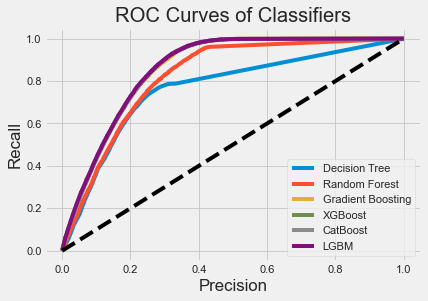

In [13]:
plt.title('ROC Curves of Classifiers')
plt.xlabel('Precision')
plt.ylabel('Recall')

for key in prob_score:
    fpr, tpr, _ = roc_curve(y_test, prob_score[key])
    plt.plot(fpr, tpr, label=key)

plt.plot((0,1), ls='dashed',color='black')
plt.legend()
plt.show()

<a id="section-four"></a>
# Hyperparameter Tuning

### Hyperparameters are important because they directly control the behaviour of the training algorithm and have a significant impact on the performance of the model is being trained. 


> ### We select **LGBM** Model for hypertuning because it has highest ROC Score

In [14]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}



clf = LGBMClassifier(max_depth=-1, random_state=15, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=100,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=15,
    verbose=True)


# Uncomment to perform Randomsearch
# gs.fit(X_train, y_train, **fit_params)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Randomsearch_params = {'colsample_bytree': 0.6261473679815167, 'min_child_samples': 237, 'min_child_weight': 0.001, 'num_leaves': 28, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.7567691135431514} 

<a id="section-five"></a>
# Model Training


In [15]:
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

#set optimal parameters
clf_sw = LGBMClassifier(**clf.get_params())
clf_sw.set_params(**Randomsearch_params)
clf_sw.fit(X_train,y_train, **fit_params, callbacks=[reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.859624
[200]	valid's auc: 0.859998
[300]	valid's auc: 0.860087
[400]	valid's auc: 0.860125
[500]	valid's auc: 0.860128
Early stopping, best iteration is:
[481]	valid's auc: 0.860136


LGBMClassifier(colsample_bytree=0.6261473679815167, metric='None',
               min_child_samples=237, n_estimators=5000, n_jobs=4,
               num_leaves=28, random_state=15, reg_alpha=10, reg_lambda=10,
               subsample=0.7567691135431514)